<a href="https://colab.research.google.com/github/TamarSdeChen/Self-Learner-DeepLearning-Course-Technion/blob/main/BYOL_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.7/619.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 54.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=98327f88f44dc226cdacdbd3fb56808092c943c208015763e6912cb20a383b4b
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import copy
import time
import os
import torch
import torchvision
from torch import nn

from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.utils.scheduler import cosine_schedule

In [ ]:
class BYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()
    self.backbone = backbone # e.g., resnet - REPRESENTATION
    self.projection_head = BYOLProjectionHead(512, 1024, 256)
    self.prediction_head = BYOLPredictionHead(256, 1024, 256)
    self.backbone_momentum = copy.deepcopy(self.backbone)
    self.projection_head_momentum = copy.deepcopy(self.projection_head)
    deactivate_requires_grad(self.backbone_momentum)
    deactivate_requires_grad(self.projection_head_momentum)

  def forward(self, x):
    y = self.backbone(x).flatten(start_dim=1)
    z = self.projection_head(y)
    p = self.prediction_head(z)
    return p
  def forward_momentum(self, x):
    y = self.backbone_momentum(x).flatten(start_dim=1)
    z = self.projection_head_momentum(y)
    z = z.detach()
    return z

In [ ]:
class BYOL_FC(nn.Module):
  def __init__(self, representation_size, hidden_size, num_clases,num_init_w):
        super(BYOL_FC, self).__init__()
        self.linear1 = nn.Linear(representation_size, hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_size, num_clases)
        #self.linear3 = nn.Linear(hidden_size, num_clases)
        self.init_weights(num_init_w)

  def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.relu(out)
        #out = self.linear3(out)

        # no softmax in the end when using crossentropy loss

        return out

  def init_weights(self, num_init_w):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        if (num_init_w == 0):
          #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          nn.init.xavier_uniform_(m.weight)
        else:
          nn.init.normal_(m.weight, 0, 0.005)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialization for BYOL
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

#load the pre-treined BYOL model
from google.colab import drive
drive.mount('/content/drive')
path_to_data = '/content/drive/MyDrive/DL_project/after_training_BYOL_150_epoch_adam.pth'
state = torch.load(path_to_data)
model.load_state_dict(state['net'])
model.to(device)
trained_BYOL_backbone = model.backbone

# create an instance of the MLP
learned_predictor_MLP = BYOL_FC(representation_size=512, hidden_size=128, num_clases=10, num_init_w=0).to(device)


# Define the combined model
class CombinedModel(nn.Module):
  def __init__(self, backbone, mlp):
    super(CombinedModel, self).__init__()
    self.backbone = backbone
    self.mlp = mlp

  def forward(self, x):
    #
    x = self.backbone(x).flatten(start_dim=1)
    #
    x = self.mlp(x)
    return x

combined_model = CombinedModel(trained_BYOL_backbone, learned_predictor_MLP)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# time to train our combined model

# hyper-parameters
learning_rate = 1e-5
num_epochs = 200

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)




In [ ]:
from torchvision.datasets import STL10
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

train_labeled_dataset = STL10(root="data", split="train", download=True, transform=ToTensor())
train_labeled_loader = torch.utils.data.DataLoader(
    train_labeled_dataset,
    batch_size=256,
    shuffle=False,
)

Files already downloaded and verified


In [ ]:
import numpy as np

avg_epoch_losses = []
combined_model.train() # change the mode to training, activating layers like DropOut and BatchNorm, if there are any
for epoch in range(num_epochs):

  total_loss = 0
  epoch_losses = []

  for batch, labels in train_labeled_loader:
    # send data to device
    batch = batch.to(device)
    labels = labels.to(device)
    # forward pass
    output = combined_model(batch) # same as model.forward(features)

    # loss
    loss = criterion(output, labels)
    total_loss += loss.detach()
    epoch_losses.append(loss.item())

    # backward pass
    optimizer.zero_grad() # clean the gradients from previous iteration
    loss.backward() # autograd backward to calculate gradients
    optimizer.step() # apply update to the weights
  if epoch % 10 == 0:
    avg_loss = total_loss / len(train_labeled_loader)
    avg_epoch_losses.append(avg_loss)

    log = "Epoch: {} | Loss: {:.4f}".format(epoch, avg_loss)
    print(log)



Epoch: 0 | Loss: 2.5730
Epoch: 10 | Loss: 1.4555
Epoch: 20 | Loss: 1.0686
Epoch: 30 | Loss: 0.8670
Epoch: 40 | Loss: 0.7414
Epoch: 50 | Loss: 0.6508
Epoch: 60 | Loss: 0.5781
Epoch: 70 | Loss: 0.5155
Epoch: 80 | Loss: 0.4593
Epoch: 90 | Loss: 0.4075
Epoch: 100 | Loss: 0.3593
Epoch: 110 | Loss: 0.3145
Epoch: 120 | Loss: 0.2726
Epoch: 130 | Loss: 0.2335
Epoch: 140 | Loss: 0.1971
Epoch: 150 | Loss: 0.1636
Epoch: 160 | Loss: 0.1333
Epoch: 170 | Loss: 0.1067
Epoch: 180 | Loss: 0.0840
Epoch: 190 | Loss: 0.0652


[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<function matplotlib.pyplot.show(close=None, block=None)>

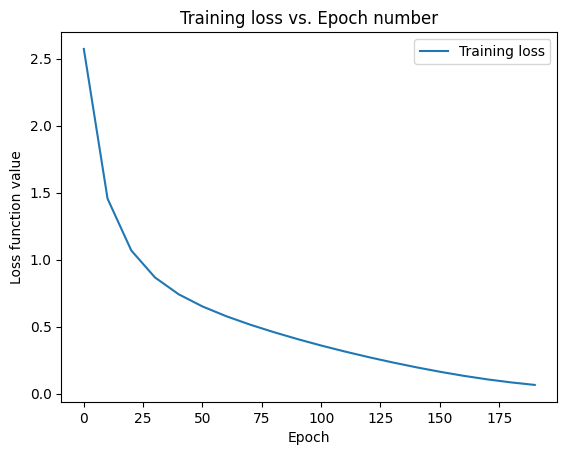

In [ ]:

from matplotlib import pyplot as plt
import numpy as np
from google.colab import files

epoch_num = np.arange(0, 200, 10, dtype=int)
print(epoch_num)
plt.plot(epoch_num, torch.as_tensor(avg_epoch_losses).cpu(), label='Training loss')
#plt.plot(validationEpoch_loss,label='val_loss')
plt.ylabel('Loss function value')
plt.xlabel('Epoch')
plt.title('Training loss vs. Epoch number')
plt.legend()
plt.savefig("fine = Training loss.png")

files.download("fine = Training loss.png")
plt.show

In [ ]:
# save model after training
print('==> Saving model ...')
state = {
'net': combined_model.state_dict(),
}

torch.save(state, '/content/drive/MyDrive/DL_project/combined_model_fine_BYOL_FC_100_epoch_01_07_.pth')

==> Saving model ...


In [ ]:
test_labeled_dataset = STL10(root="data", split="test", download=True, transform=ToTensor())
test_labeled_loader = torch.utils.data.DataLoader(
    test_labeled_dataset,
    batch_size=256,
    shuffle=False,
)


Files already downloaded and verified


In [ ]:
def eval_BYOL_FC(model, dataloader, device=torch.device('cuda:0')):
  model.eval() # put in evaluation mode
  model_output = []
  labels = []
  num_samples = 0
  num_correct = 0
  with torch.no_grad():
    for data in dataloader:
      images, label = data
      images = images.to(device)
      label = label.to(device)
      output = model(images)
      model_output.append(output)
      labels.append(label.cpu())

      # values, index
      _, predictions = torch.max(output,1)
      num_samples += label.shape[0]
      num_correct += (predictions == label).sum().item()
    print(num_samples,num_correct)
    accuracy = 100.0 * (num_correct / num_samples)
    print('test accuracy = {}'.format(accuracy))
    model_output = torch.cat(model_output)
    labels = torch.cat(labels)

  return model_output.detach(), labels.detach()

In [ ]:
model_output, labels = eval_BYOL_FC(combined_model, test_labeled_loader, device=device)

8000 6151
test accuracy = 76.8875
